# Demo: Pipeline with FI-GRL 

Two global parameters need to be defined for this pipeline. The embedding size of figrl's embeddings, and a boolean variable 'add additional data'. The latter is set to True so that the original transaction node data is added to the embeddings before classifications are made by our downstream classifier. It is advised to set this parameter to true, given that transaction features have proven to be very useful in traditional fraud detection. 

In [1]:
# Global parameters:
embedding_size = 64
add_additional_data = True

### 1. Loading the Credit Card Transaction Data

Load numeric, artificially generated transaction data. 

In [27]:
import pandas as pd 
import numpy as np
import networkx as nx

df = pd.read_csv("demo_ccf.csv")

the `train_data` variable stores the data that will be used to construct graphs on which the representation learners can train. 
the `inductive_data` will be used to test the inductive performance of our representation learning algorithms.

In [28]:
cutoff = round(0.6*len(df)) # first 60% of transactions are used for training, last 40% to test inductive capability
train_data = df.head(cutoff)
inductive_data = df.tail(len(df)-cutoff)

In [29]:
print('The distribution of fraud for the train data is:\n', train_data['fraud_label'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['fraud_label'].value_counts())

The distribution of fraud for the train data is:
 0    482
1    164
Name: fraud_label, dtype: int64
The distribution of fraud for the inductive data is:
 0    327
1    103
Name: fraud_label, dtype: int64


### 2. Construct the Credit Card Transaction Network

nodes and edges are passed to the GraphConstruction constructor. The FI-GRL framework derives embeddings starting from an adjacency matrix that it constructs using the graph's edgelist. 

In [5]:
from inductiveGRL.graphconstruction import GraphConstruction

nodes = {"client":train_data.client_node, "merchant":train_data.merchant_node, "transaction":train_data.index}
edges = [zip(train_data.client_node, train_data.index),zip(train_data.merchant_node, train_data.index)]

graph = GraphConstruction(nodes, edges)


In [6]:
# The FIGRL implementation requires that all nodes are integers, hence we relabel all nodes. 
graph.g_nx = nx.convert_node_labels_to_integers(graph.g_nx, label_attribute='original_label')

In [7]:
# Create translation dictionaries to retrieve the original node labels
node_dict = nx.get_node_attributes(graph.g_nx, 'original_label')
dict_node = {v:k for k,v in node_dict.items()}

## 2.1. Train FI-GRL

FI-GRL, a fast inductive graph representation framework is trained using the aforeconstructed graph. First, we instantiate the FI-GRL class with the intermediate dimension of the matrix between the input graph and the embedding space, in addition to the size of final dimension (embedding space). FI-GRL's train step returns three matrices: U, which represents the embedding space, sigma and v, which are matrices that will be used in the inductive step to generate embeddings for unseen nodes. 

In [30]:
#FIGRL hyperparameter
intermediate_dim = 400

In [31]:
from FIGRL import FIGRL
model = FIGRL(embedding_size, intermediate_dim)

In [32]:
all_train_embeddings = model.fit(graph.g_nx)

In [33]:
# Only get the embeddings from transaction nodes
figrl_train_emb = all_train_embeddings[-len(train_data):]

In [12]:
# Convert index of the embeddings back to original transaction ids. 
figrl_train_emb.index = [node_dict[x] for x in figrl_train_emb.index]

## 2.2. Inductive Step FI-GRL

We want to keep the original indices after concatenating the train and inductive data, because they represent the transaction node ids. We need to concatenate these dataframes in order to easily construct the new graph.

In [13]:
pd.options.mode.chained_assignment = None

train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

A new graph is constructed, which contains the previous nodes in addition to the inductive nodes. FI-GRL will induce embeddings for these unseen nodes using matrices from the train step.

In [14]:
nodes = {"client":inductive_graph_data.client_node, "merchant":inductive_graph_data.merchant_node, "transaction":inductive_graph_data.index}
edges = [zip(inductive_graph_data.client_node, inductive_graph_data.index),zip(inductive_graph_data.merchant_node, inductive_graph_data.index)]

graph = GraphConstruction(nodes, edges)
#figrl_graph = graph.get_edgelist()


In [15]:
# The FIGRL implementation requires that all nodes are integers, hence we relabel all nodes. 
graph.g_nx = nx.convert_node_labels_to_integers(graph.g_nx, label_attribute='original_label')

In [16]:
# Create translation dictionaries to retrieve the original node labels
node_dict = nx.get_node_attributes(graph.g_nx, 'original_label')
dict_node = {v:k for k,v in node_dict.items()}

The inductive step performs computations with the new adjacency matrix and the during training calculated matrices sigma and v. 

For efficiency reasons, FIGRL requires a list of Pandas Series. For each node type connected that can be connected to a transaction node, FIGRL needs a separate Pandas Series. In this case we need a Pandas Series for the client nodes and a Pandas Series for the merchant nodes. Make sure each Pandas Series contains the integer ids of the corresponding nodes in the relabeled graph. 

In [17]:
# Create three new columns in which the integer node ids from the relabeled graph are stored. 
inductive_data['t_node_id'] = [dict_node[t] for t in inductive_data.index]
inductive_data['c_node_id'] = [dict_node[c] for c in inductive_data.client_node]
inductive_data['m_node_id'] = [dict_node[m] for m in inductive_data.merchant_node]

In [18]:
# The largest integer id in our relabeled network
max_id = graph.g_nx.number_of_nodes()

In [19]:
inductive_data_tx_node_index = inductive_data.set_index('t_node_id')
list_connected_node_types = [inductive_data_tx_node_index.c_node_id, inductive_data_tx_node_index.m_node_id]

In [21]:
figrl_inductive_emb = model.predict(graph.g_nx, inductive_data_tx_node_index, list_connected_node_types, maxid=max_id, inductive_index=inductive_data_tx_node_index.index)

In [22]:
# Translate back to original node labels
figrl_inductive_emb.index = [node_dict[t] for t in figrl_inductive_emb.index]

In [23]:
# Drop the columns you added temporarily for FIGRL predict. 
inductive_data = inductive_data.drop(['t_node_id', 'c_node_id', 'm_node_id'], axis=1)

### 4. Classification: predictions based on inductive embeddings

Select your preferred classification model

In [24]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

If requested, the original transaction features are added to the generated embeddings. If these features are added, a baseline consisting of only these features (without embeddings) is included to analyze the net impact of embeddings on the predictive performance.

In [25]:
train_labels = train_data['fraud_label']

if add_additional_data is True:
    train_emb = pd.merge(figrl_train_emb, train_data.loc[figrl_train_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)
    inductive_emb = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('fraud_label', axis=1), left_index=True, right_index=True)

    baseline_train = train_data.drop('fraud_label', axis=1)
    baseline_inductive = inductive_data.drop('fraud_label', axis=1)

    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)
    
classifier.fit(train_emb, train_labels)
predictions = classifier.predict_proba(inductive_emb)


/Users/raf/opt/anaconda3/envs/eswa_revision/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 5. Evaluation

Given the highly imbalanced nature of our dataset, we evaluate the results based on precision-recall curves. 

Average precision-recall score XGBoost: 0.8510851210
Average precision-recall score XGBoost: 0.8197498524


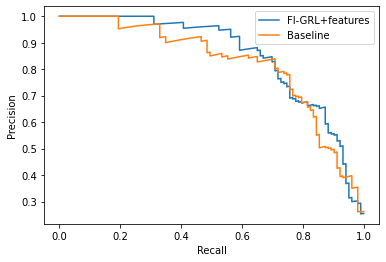

In [26]:
from inductiveGRL.evaluation import Evaluation
inductive_labels = df.loc[inductive_emb.index]['fraud_label']

figrl_evaluation = Evaluation(predictions, inductive_labels, "FI-GRL+features") 
figrl_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()